# Comparison Tables By Metrice Scores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from impyute.imputation.cs import fast_knn
import pickle

# Scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Ignoring Errors
import warnings
warnings.simplefilter('ignore')

In [2]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
scoring = make_scorer(roc_auc_score)
def gsearch(classifier, X_train, y_train, param_grid, scoring=scoring):
    gs = GridSearchCV(estimator=classifier,
                      param_grid=param_grid, 
                      scoring=scoring,
                      cv=5,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    return (gs.best_score_, gs.best_params_, gs.best_estimator_)

def collect_scores(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
    
    tpr = tp/(tp + fn)
    tnr = tn/(fp + tn)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    plr = tpr/(1 - tnr)
    nlr = (1 - tpr)/tnr
    y_test_size = y_test.shape[0]
    fn = fn/y_test_size
    fp = fp/y_test_size
    return [tpr, tnr, fn, fp, ppv, npv, plr, nlr, auc]

In [3]:
def best_estimator(X, y):
    best_lr, best_svm, best_rf = [0, 0], [0, 0], [0, 0]

    pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(n_jobs=-1, random_state=1)]])
    pipe_svm = Pipeline([['sc', StandardScaler()], ['clf', SVC(probability=True, random_state=1)]])
    rf = RandomForestClassifier(random_state=1, n_jobs=-1)

    lr_grid = [{'clf__C': param_range,
            'clf__penalty': ['l1','l2']}]

    svm_grid = [{'clf__C': param_range,
                'clf__kernel': ['rbf','sigmoid']}]
    
    rf_grid = [{
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}]

    kf = StratifiedKFold(10, random_state=1)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = gsearch(pipe_lr, X_train, y_train, lr_grid)
        svm = gsearch(pipe_svm, X_train, y_train, svm_grid)
        rf_best = gsearch(rf, X_train, y_train, rf_grid)
        if lr[0] > best_lr[0]:
            best_lr[0] = lr[0]
            best_lr[1] = lr
        if svm[0] > best_svm[0]: 
            best_svm[0] = svm[0]
            best_svm[1] = svm
        if rf_best[0] > best_rf[0]: 
            best_rf[0] = rf_best[0]
            best_rf[1] = rf_best
            
    return (best_lr[1][2], best_svm[1][2], best_rf[1][2], (best_lr[1][1], best_svm[1][1], best_rf[1][1]))

In [4]:
def return_confusion(classifiers, X_train, X_test, y_train, y_test):
    confmats = []
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        confmats.append(confmat)
    return confmats

def plot_confusion(classifiers, X_train, X_test, y_train, y_test, title, save=False):
    clf_names = ["LR", "SVM", "RF", "BAGGING"]
    confmats = return_confusion(classifiers, X_train, X_test, y_train, y_test)
    plt.figure(figsize=(6,6))
    for ax_num, cnfm, clf_name in zip([221,222,223,224], confmats, clf_names):
        ax = plt.subplot(ax_num)
        ax.title.set_text(clf_name)

        ax.matshow(cnfm, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(cnfm.shape[0]):
            for j in range(cnfm.shape[1]):
                ax.text(x=j, y=i, s=cnfm[i, j], va='center', ha='center')
        
        plt.xlabel('predicted label')
        plt.ylabel('true label')

    plt.suptitle(title, y=1.05, fontsize=16)
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

# Importing Data

In [5]:
data = pd.read_excel("NAFLD with FIB4 and NFS Scores.xlsx").drop(294)
features_df = data.iloc[:,1:-13].drop(['Height', 'Weight'], axis=1)
targets_df = data[['Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)',
                         'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)']]

In [6]:
baseline2 = features_df.dropna(axis=1) # shape: (604, 16)

In [7]:
baseline2.columns

Index(['Age', 'Gender (Female=1, Male=2)', 'Body Mass Index',
       'Systolic Blood Pressure', 'Diastolic Blood Pressure',
       'Diyabetes Mellitus (No=0, Yes=1)', 'Hypertension (No=0, Yes=1)',
       'Hyperlipidemia (No=0, Yes=1)', 'Metabolic syndrome (No=0, Yes=1)',
       'AST', 'ALT', 'Albumin', 'Total Cholesterol', 'Leukocyte', 'Hemoglobin',
       'Trombosit'],
      dtype='object')

## Baseline (No missed values)

In [8]:
models_4_SF = best_estimator(baseline2.values, targets_df.iloc[:,0].values)
models_4_AF = best_estimator(baseline2.values, targets_df.iloc[:,1].values)

In [9]:
models_4_AF[3] # best parameters of the models

({'clf__C': 0.001, 'clf__penalty': 'l2'},
 {'clf__C': 10.0, 'clf__kernel': 'rbf'},
 {'bootstrap': True,
  'max_depth': 80,
  'max_features': 3,
  'min_samples_leaf': 3,
  'min_samples_split': 8,
  'n_estimators': 200})

In [10]:
lr_best_sf, svm_best_sf, rf_best_sf = models_4_SF[0], models_4_SF[1], models_4_SF[2]
lr_best_af, svm_best_af, rf_best_af = models_4_AF[0], models_4_AF[1], models_4_AF[2]

In [11]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1, random_state=1)

sf_models = [lr_best_sf, svm_best_sf, rf_best_sf, bagging]
af_models = [lr_best_af, svm_best_af, rf_best_af, bagging]

In [12]:
comparison_table = {}
kf = StratifiedKFold(10, random_state=1)
X = baseline2.values

for idx, models in enumerate([sf_models, af_models]):
    if idx == 0: target = "SF"
    else: target = "AF"
    comparison_table.setdefault(target, [])
    for mdl in models:
        avrg = []
        y = targets_df.iloc[:,idx].values
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table[target].append(avrg_list)

In [13]:
columns = ['Sensitivity (%)', 'Specificity (%)', 'FN', 'FP', 'PPV', 'NPV', 'PLR', 'NLR', 'AUC']
index = ['LR', 'SVM', 'RandomForest', 'Bagging']
index1 = pd.MultiIndex.from_tuples([('SIGNIFICANT', 'LR'), ('FIBROSIS', 'SVM'), ('','RandomForest'), ('', 'Bagging')])
sf_table_df = pd.DataFrame(np.array(comparison_table['SF']), index=index1, columns=columns)
sf_table_df

Sensitivity (%)  Specificity (%)     FN     FP  \
SIGNIFICANT LR                       54.0             78.0  0.167  0.141   
FIBROSIS    SVM                      40.0             82.0  0.219  0.116   
            RandomForest             39.0             85.0  0.220  0.095   
            Bagging                  42.0             81.0  0.208  0.124   

                            PPV    NPV    PLR    NLR    AUC  
SIGNIFICANT LR            0.576  0.752  2.689  0.602  0.701  
FIBROSIS    SVM           0.556  0.707  2.556  0.743  0.708  
            RandomForest  0.612  0.712  3.545  0.722  0.742  
            Bagging       0.557  0.712  2.760  0.728  0.700

In [14]:
index2 = pd.MultiIndex.from_tuples([('ADVANCED', 'LR'), ('FIBROSIS', 'SVM'), ('', 'RandomForest'), ('', 'Bagging')])
af_table_df = pd.DataFrame(np.array(comparison_table['AF']), index=index2, columns=columns)
af_table_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
ADVANCED LR                       39.0             89.0  0.109  0.088  0.449   
FIBROSIS SVM                      33.0             90.0  0.119  0.078  0.496   
         RandomForest             10.0             99.0  0.162  0.012  0.483   
         Bagging                  23.0             95.0  0.137  0.038  0.517   

                         NPV    PLR    NLR    AUC  
ADVANCED LR            0.871  4.475  0.686  0.764  
FIBROSIS SVM           0.862  3.967  0.736  0.738  
         RandomForest  0.834  6.676  0.918  0.780  
         Bagging       0.851  6.348  0.805  0.762

### Confusion Matrices

In [15]:
X_train_sf_0, X_test_sf_0, y_train_sf_0, y_test_sf_0 = train_test_split(
    baseline2.values, targets_df.iloc[:,0].values, test_size=0.2, random_state=1, stratify= y)

X_train_af_0, X_test_af_0, y_train_af_0, y_test_af_0 = train_test_split(
    baseline2.values, targets_df.iloc[:,1].values, test_size=0.2, random_state=1, stratify= y)

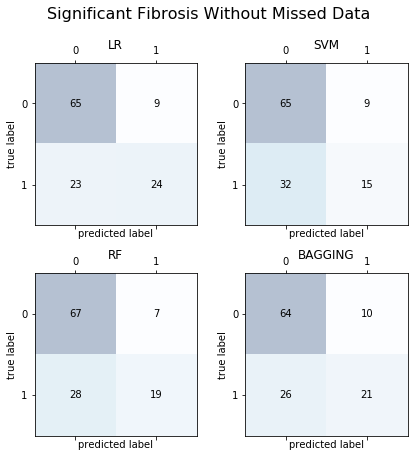

In [16]:
sf_title_0 = "Significant Fibrosis Without Missed Data"
plot_confusion(sf_models, X_train_sf_0, X_test_sf_0, y_train_sf_0, y_test_sf_0, sf_title_0, save=False)

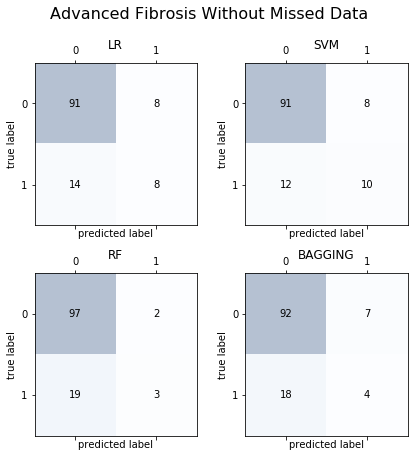

In [17]:
af_title_0 = "Advanced Fibrosis Without Missed Data"
plot_confusion(af_models, X_train_af_0, X_test_af_0, y_train_af_0, y_test_af_0, af_title_0, save=False)

## 25% Threshold

In [18]:
missing_data_percentages = features_df.isnull().mean()
threshold_25_df = features_df.iloc[:, missing_data_percentages.values < 0.25]
knn_25 = fast_knn(threshold_25_df.values, k=30)

In [19]:
models_25_SF = best_estimator(knn_25, targets_df.iloc[:,0].values)
models_25_AF = best_estimator(knn_25, targets_df.iloc[:,1].values)

In [20]:
models_25_AF[3] # best parameters of the models

({'clf__C': 0.001, 'clf__penalty': 'l2'},
 {'clf__C': 100.0, 'clf__kernel': 'rbf'},
 {'bootstrap': True,
  'max_depth': 80,
  'max_features': 3,
  'min_samples_leaf': 3,
  'min_samples_split': 8,
  'n_estimators': 100})

In [21]:
lr_best_sf_25, svm_best_sf_25, rf_best_sf_25 = models_25_SF[0], models_25_SF[1], models_25_SF[2]
lr_best_af_25, svm_best_af_25, rf_best_af_25 = models_25_AF[0], models_25_AF[1], models_25_AF[2]

In [22]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1, random_state=1)

sf_25_models = [lr_best_sf_25, svm_best_sf_25, rf_best_sf_25, bagging]
af_25_models = [lr_best_af_25, svm_best_af_25, rf_best_af_25, bagging]

In [23]:
comparison_table_25 = {}
kf = StratifiedKFold(10, random_state=1)
X = knn_25

for idx, models in enumerate([sf_25_models, af_25_models]):
    if idx == 0: target = "SF"
    else: target = "AF"
    comparison_table_25.setdefault(target, [])
    for mdl in models:
        avrg = []
        y = targets_df.iloc[:,idx].values
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table_25[target].append(avrg_list)

In [24]:
index3 = pd.MultiIndex.from_tuples([('SIGNIFICANT', 'LR'), ('FIBROSIS', 'SVM'), ('', 'RandomForest'), ('', 'Bagging')])
sf_table_25_df = pd.DataFrame(np.array(comparison_table_25['SF']), index=index3, columns=columns)
sf_table_25_df

Sensitivity (%)  Specificity (%)     FN     FP  \
SIGNIFICANT LR                       49.0             81.0  0.184  0.123   
FIBROSIS    SVM                      46.0             79.0  0.197  0.136   
            RandomForest             33.0             88.0  0.241  0.076   
            Bagging                  36.0             82.0  0.232  0.113   

                            PPV    NPV    PLR    NLR    AUC  
SIGNIFICANT LR            0.587  0.739  3.624  0.643  0.714  
FIBROSIS    SVM           0.547  0.720  2.960  0.709  0.689  
            RandomForest  0.616  0.701  3.496  0.769  0.722  
            Bagging       0.539  0.696  2.267  0.780  0.675

In [25]:
index4 = pd.MultiIndex.from_tuples([('ADVANCED', 'LR'), ('FIBROSIS', 'SVM'), ('', 'RandomForest'), ('', 'Bagging')])
af_table_25_df = pd.DataFrame(np.array(comparison_table_25['AF']), index=index4, columns=columns)
af_table_25_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
ADVANCED LR                       53.0             84.0  0.084  0.128  0.438   
FIBROSIS SVM                      33.0             92.0  0.121  0.068  0.439   
         RandomForest              8.0            100.0  0.164  0.002  0.800   
         Bagging                  17.0             95.0  0.149  0.040  0.351   

                         NPV    PLR    NLR    AUC  
ADVANCED LR            0.893  4.074  0.555  0.781  
FIBROSIS SVM           0.865  4.392  0.725  0.751  
         RandomForest  0.834  0.000  0.918  0.782  
         Bagging       0.841  4.372  0.870  0.720

### Confusion Matrices

In [26]:
X_train_sf_25, X_test_sf_25, y_train_sf_25, y_test_sf_25 = train_test_split(
    knn_25, targets_df.iloc[:,0].values, test_size=0.2, random_state=1, stratify=y)

X_train_af_25, X_test_af_25, y_train_af_25, y_test_af_25 = train_test_split(
    knn_25, targets_df.iloc[:,1].values, test_size=0.2, random_state=1, stratify=y)

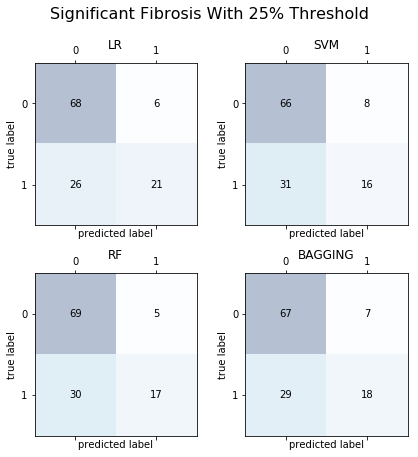

In [27]:
sf_title_25 = "Significant Fibrosis With 25% Threshold"
plot_confusion(sf_25_models, X_train_sf_25, X_test_sf_25, y_train_sf_25, y_test_sf_25, sf_title_25, save=False)

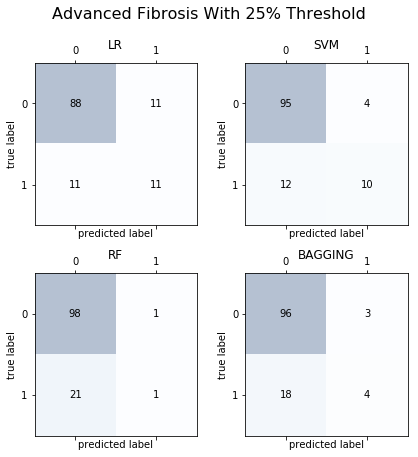

In [28]:
af_title_25 = "Advanced Fibrosis With 25% Threshold"
plot_confusion(af_25_models, X_train_af_25, X_test_af_25, y_train_af_25, y_test_af_25, af_title_25, save=False)

## Keeping Models In The Storage

In [29]:
keep_models = {'0':{'SF':models_4_SF, 'AF':models_4_AF},
               '25':{'SF':models_25_SF, 'AF':models_25_AF}}
with open('workingOnFibrosis1_best_models.db','wb') as models:
    pickle.dump(keep_models, models)